In [1]:
import os, sys

recsys_cf = os.environ.get("RECSYS_STORY")
sys.path.append(recsys_cf)
os.chdir(recsys_cf)

from lib.tools import *

In [2]:
%matplotlib inline

In [3]:
# Preproc
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score,  f1_score

# Model
from pyspark.ml.recommendation import ALS, ALSModel

### SPARK 

In [4]:
sp = spark(**SPARK_CONFIG)
hive = sp.sql

In [95]:
SPARK_CONFIG

{'kerberos_auth': True,
 'numofcores': 12,
 'numofinstances': 12,
 'process_label': 'RECSYS_STORY',
 'replication_num': 1}

### Load data 

In [10]:
train_sdf = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET_POSITIVE, hive)

In [11]:
test_sdf = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET_TARGET, hive)

In [12]:
item_dict = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_ITEM_DICT, hive)

In [13]:
user_dict = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_USER_DICT, hive)

### Train ALS 

In [14]:
test_sdf.filter("rating = 1").count()

26400

In [17]:
MODEL_PARAMS

{'alpha': 1, 'maxIter': 6, 'nonnegative': False, 'rank': 10, 'regParam': 1.0}

In [16]:
MODEL_HEADER

{'implicitPrefs': True,
 'itemCol': 'item_id',
 'ratingCol': 'rating',
 'userCol': 'user_id'}

In [19]:
als = ALS(
          **MODEL_HEADER,
          **MODEL_PARAMS
         )

In [20]:
%%time
model = als.fit(train_sdf)

CPU times: user 22.3 ms, sys: 19.6 ms, total: 41.8 ms
Wall time: 20.7 s


### ALS make prediction

In [21]:
%%time
pred_sdf = model.transform(test_sdf)

CPU times: user 6.59 ms, sys: 1.65 ms, total: 8.24 ms
Wall time: 42.6 ms


In [22]:
pred_sdf.show(3)

,user_id,item_id,timestamp,rating,prediction
0,471,214250791,None,0.0,-0.000080
1,496,214250791,None,0.0,0.000244
2,1088,214250791,None,0.0,0.000923


In [24]:
pred_sdf.count()

12608765

### Make stats on test group

###### статистика на юзерах, у которых есть целевые события 

In [45]:
test_user_df = test_sdf.filter("rating = 1").select(f.col("user_id").alias("t_user_id")).distinct()

In [46]:
test_user_df.count()

22746

In [47]:
%%time
pred = pred_sdf.join(test_user_df,
                     pred_sdf.user_id == test_user_df.t_user_id,
                     how='inner')\
               .drop("t_user_id").toPandas()

CPU times: user 1.01 s, sys: 94.3 ms, total: 1.11 s
Wall time: 11.9 s


гистограмма рейтингов **до нормализации**

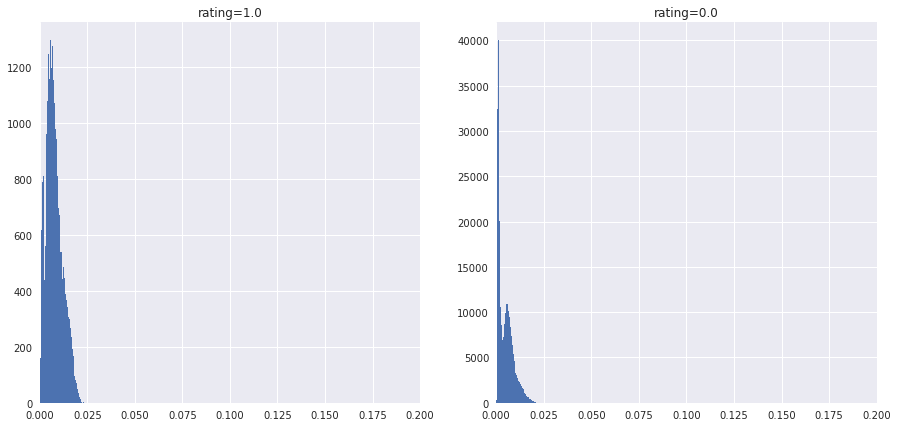

In [48]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1), plt.xlim((0, 0.2))
plt.hist(pred[pred.rating == 1.0].prediction, bins=50), 
plt.title("rating=1.0")

plt.subplot(1, 2, 2), plt.xlim((0, 0.2))
plt.hist(pred[pred.rating == 0.0].prediction, bins=50), 
plt.title("rating=0.0")
None

###### нормализация 

In [49]:
pred["prediction_raw"] = pred["prediction"]
pred["prediction"] = MinMaxScaler().fit_transform(pred[["prediction"]])

In [51]:
pred.head(3)

,user_id,item_id,timestamp,rating,prediction,prediction_raw
0,24347,214314599,NaN,0.0,0.309851,0.007024
1,24347,214337742,NaN,0.0,0.071417,0.001372
2,24347,214228698,NaN,0.0,0.242183,0.005420


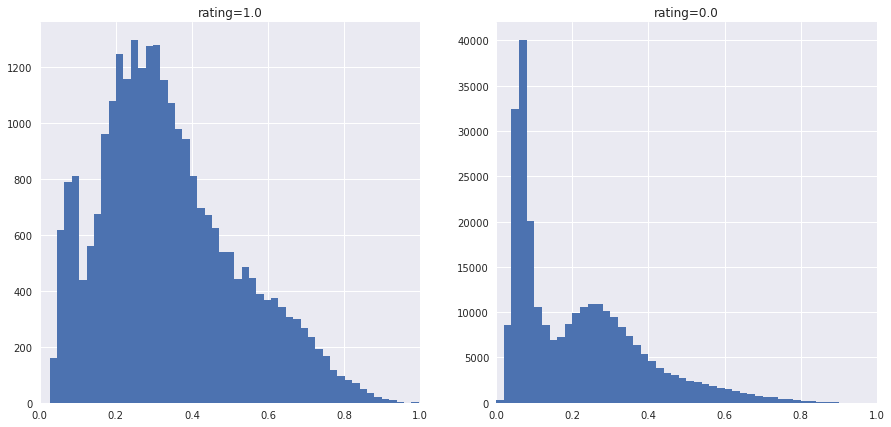

In [53]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1), plt.xlim((0, 1))
plt.hist(pred[pred.rating == 1.0].prediction, bins=50), 
plt.title("rating=1.0")

plt.subplot(1, 2, 2), plt.xlim((0, 1))
plt.hist(pred[pred.rating == 0.0].prediction, bins=50), 
plt.title("rating=0.0")
None

In [87]:
pred_col = [pred.rating, pred.prediction]

roc_auc = roc_auc_score(*pred_col)
log_loss_score = log_loss(*pred_col)

print("ROC_AUC: {:.4f}".format(roc_auc))
print("Log loss: {:.4f}".format(log_loss_score))

ROC_AUC: 0.7081
Log loss: 0.3595


In [88]:
fpr, tpr, thresholds_roc = roc_curve(*pred_col)

sensitivity = tpr
specificity = 1 - fpr
gmeans = np.sqrt(sensitivity * specificity)

ix_gmean = np.argmax(gmeans)
best_thresholds_roc = thresholds_roc[ix_gmean]
best_gmean = gmeans[ix_gmean]

print("Best thresholds: {:.4f} for G-mean: {:.4f}".format(best_thresholds_roc, best_gmean))

Best thresholds: 0.2343 for G-mean: 0.6424


In [89]:
precision, recall, thresholds_pr = precision_recall_curve(*pred_col)

fscore = (2 * precision * recall) / (precision + recall)
fscore[np.isnan(fscore)] = 0

ix_fscore = np.argmax(fscore)
best_thresholds_pr = thresholds_pr[ix_fscore]
best_fscore = fscore[ix_fscore]

print("Best thresholds: {:.4f} for F-score: {:.4f}".format(best_thresholds_pr, best_fscore))

Best thresholds: 0.3086 for F-score: 0.2459


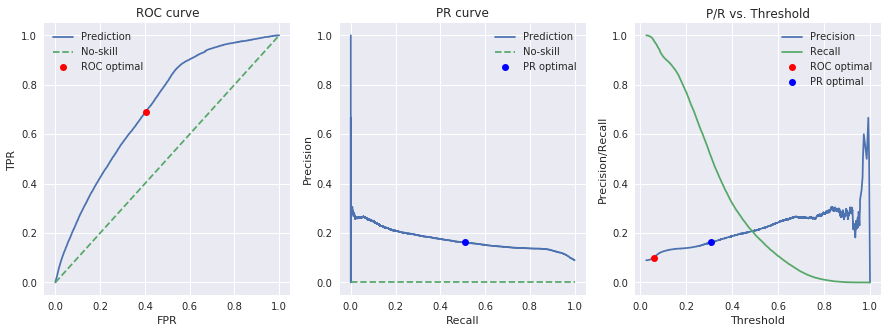

In [90]:
plt.figure(figsize=(15, 5))

#############################################################

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, "-", label="Prediction")
plt.plot([0, 1], [0, 1], "--", label="No-skill")
plt.plot(fpr[ix_gmean], tpr[ix_gmean], "or", label="ROC optimal")

plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

#############################################################

plt.subplot(1, 3, 2)
plt.plot(recall, precision, "-", label="Prediction")
plt.plot([0, 1], [0, 0], "--", label="No-skill")
plt.plot(recall[ix_fscore], precision[ix_fscore], "ob", label="PR optimal")

plt.title("PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

#############################################################

plt.subplot(1, 3, 3)
plt.plot(thresholds_pr, precision[:-1], label="Precision")
plt.plot(thresholds_pr, recall[:-1], label="Recall")
plt.plot(thresholds_pr[ix_gmean], precision[ix_gmean], "or", label="ROC optimal")
plt.plot(thresholds_pr[ix_fscore], precision[ix_fscore], "ob", label="PR optimal")

plt.title("P/R vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend()

plt.show()

In [91]:
print("Report for best ROC threshold: {:.4f}\n".format(best_thresholds_roc))
print(classification_report(pred.rating, pred.prediction > best_thresholds_roc))

print("-"*60)

print("Report for best PR threshold: {:.4f}\n".format(best_thresholds_pr))
print(classification_report(pred.rating, pred.prediction > best_thresholds_pr))

Report for best ROC threshold: 0.2343

              precision    recall  f1-score   support

         0.0       0.95      0.60      0.73    269298
         1.0       0.14      0.69      0.24     26400

   micro avg       0.61      0.61      0.61    295698
   macro avg       0.55      0.64      0.49    295698
weighted avg       0.88      0.61      0.69    295698

------------------------------------------------------------
Report for best PR threshold: 0.3086

              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83    269298
         1.0       0.16      0.51      0.25     26400

   micro avg       0.72      0.72      0.72    295698
   macro avg       0.55      0.63      0.54    295698
weighted avg       0.87      0.72      0.78    295698



In [92]:
pred_crisp_list = [pred.rating, pred.prediction > best_thresholds_roc]

In [93]:
tn, fp, fn, tp = confusion_matrix(*pred_crisp_list).ravel()
print("TP: {}, FP: {}".format(tp, fp))
print("FN: {}, TN: {}".format(fn, tn))

TP: 18250, FP: 108557
FN: 8150, TN: 160741


In [94]:
precision_s = precision_score(*pred_crisp_list)
recall_s = recall_score(*pred_crisp_list)
f1_s = f1_score(*pred_crisp_list)

print("Precision: {:.4f}".format(precision_s))
print("Recall: {:.4f}".format(recall_s))
print("F1-score: {:.4f}".format(f1_s))

Precision: 0.1439
Recall: 0.6913
F1-score: 0.2382


In [95]:
print("ROC_AUC: {:.4f}".format(roc_auc))

print("Precision: {:.4f}".format(precision_s))
print("Recall: {:.4f}".format(recall_s))
print("F1-score: {:.4f}".format(f1_s))


print("TP: {}, FP: {}".format(tp, fp))
print("FN: {}, TN: {}".format(fn, tn))

print("Log loss: {:.4f}".format(log_loss_score))

ROC_AUC: 0.7081
Precision: 0.1439
Recall: 0.6913
F1-score: 0.2382
TP: 18250, FP: 108557
FN: 8150, TN: 160741
Log loss: 0.3595


### Range metrics 

In [54]:
micro_rec = "/home/shubochkin1-ei_ca-sbrf-ru/notebooks/recsys360/libs/microsoft_recommenders/"

In [55]:
import sys
sys.path.append(micro_rec)

from reco_utils.common.timer import Timer
from reco_utils.dataset import movielens
from reco_utils.common.notebook_utils import is_jupyter
from reco_utils.dataset.spark_splitters import spark_random_split
from reco_utils.evaluation.spark_evaluation import SparkRatingEvaluation, SparkRankingEvaluation
from reco_utils.common.spark_utils import start_or_get_spark

print("System version: {}".format(sys.version))
print("Spark version: {}".format(pyspark.__version__))

System version: 3.5.3 |Anaconda custom (64-bit)| (default, Mar  6 2017, 11:58:13) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Spark version: 2.4.0


In [56]:
model_prediction = pred_sdf
true_metrics = model_prediction.filter(f.col("rating") == 1)

###### Подсчет метрик ранжирования в Спарке 

In [60]:
MAP_K = list()
NDCG_K = list()

for TOP_K in range(1, 13):
    rank_eval_k = SparkRankingEvaluation(true_metrics,\
                                         model_prediction,\
                                         k = TOP_K,\
                                         col_user="user_id",\
                                         col_item="item_id",\
                                         col_rating="rating",\
                                         col_prediction="prediction",\
                                         relevancy_method="top_k")
    MAP_K.append(rank_eval_k.map_at_k())
    NDCG_K.append(rank_eval_k.ndcg_at_k())

популярная модель

In [62]:
popular_items = true_metrics.groupBy(f.col("item_id")).\
                             agg(f.count("item_id").alias("item_ratio")).\
                             orderBy(f.col("item_ratio").desc()).\
                             cache()

In [67]:
popular_items.show(16)

,item_id,item_ratio
0,214230946,5125
1,214243813,4377
2,214338729,3547
3,214300159,2656
4,214314599,2340
5,214240895,2281
6,214204148,2136
7,214228698,1765
8,214224178,806
9,214238693,446


In [69]:
item_cnt = int(popular_items.select(f.sum(f.col("item_ratio"))).toPandas()['sum(item_ratio)'][0])
item_cnt

26400

In [76]:
popular_rating = popular_items.select(f.col("item_id"), (f.col("item_ratio") / item_cnt).alias("prediction")).\
                                    select(f.col("item_id"), f.col("prediction"))

In [78]:
users = model_prediction.select(f.col("user_id")).distinct()
users.count()

969905

In [79]:
popular_prediction = popular_rating.crossJoin(users).select(f.col("user_id"), f.col("item_id"), f.col("prediction"))

In [81]:
MAP_K_POP = list()
NDCG_K_POP = list()

for TOP_K in range(1, 13):
    rank_eval_popular_k = SparkRankingEvaluation(true_metrics,\
                                         popular_prediction,\
                                         k = TOP_K,\
                                         col_user="user_id",\
                                         col_item="item_id",\
                                         col_rating="rating",\
                                         col_prediction="prediction",\
                                         relevancy_method="top_k")
    MAP_K_POP.append(rank_eval_popular_k.map_at_k())
    NDCG_K_POP.append(rank_eval_popular_k.ndcg_at_k())

Сравнение с популярной моделью

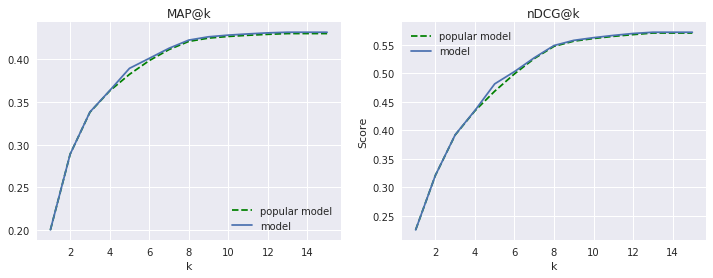

In [84]:
N = list(range(1,16))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax1.set_title("MAP@k")
ax1.plot(N, MAP_K_POP, 'g--', label="popular model")
ax1.plot(N, MAP_K, label="model")
ax1.set_xlabel("k")
ax1.legend()


ax2.set_title("nDCG@k")
ax2.plot(N, NDCG_K_POP, 'g--', label="popular model")
ax2.plot(N, NDCG_K, label="model")
ax2.set_xlabel("k")
ax2.legend()

plt.ylabel("Score")
plt.show()

###### Getting final data 

In [104]:
target_item_sdf = item_dict.filter(f.col("product").isin(PRODUCT_LIST)).select("item_id", "product").distinct()

In [109]:
inn_prod_rating_sdf = pred_sdf.join(target_item_sdf, "item_id", "inner")\
                              .join(user_dict, "user_id", "inner")\
                              .select(f.col("inn").alias("INN"),
                                      f.col("product").alias("PRODUCT_ID"),
                                      f.col("prediction").alias("PRODUCT_RATING"),
                                      f.col("rating").alias("TRUE_RATING"))

In [110]:
inn_prod_rating_sdf.filter("TRUE_RATING = 1").select("INN").distinct().count()

22746

In [118]:
inn_prod_rating_pdf = inn_prod_rating_sdf.toPandas()

In [120]:
inn_prod_rating_pdf.head()

,INN,PRODUCT_ID,PRODUCT_RATING,TRUE_RATING
0,010400799930,kredit,6.727757e-03,0.0
1,010400799930,leasing,2.241299e-04,0.0
2,010400799930,sberrating,2.714388e-03,0.0
3,010400799930,two_gis,-1.251901e-07,0.0
4,010400799930,korpkarta,1.938640e-03,0.0


In [124]:
inn_prod_rating_pdf["PRODUCT_RATING_NORM"] = inn_prod_rating_pdf["PRODUCT_RATING"]
inn_prod_rating_pdf["PRODUCT_RATING_NORM"] = MinMaxScaler().fit_transform(inn_prod_rating_pdf[["PRODUCT_RATING_NORM"]])

In [126]:
inn_prod_rating_pdf.head()

,INN,PRODUCT_ID,PRODUCT_RATING,TRUE_RATING,PRODUCT_RATING_NORM
0,010400799930,kredit,6.727757e-03,0.0,0.295433
1,010400799930,leasing,2.241299e-04,0.0,0.041729
2,010400799930,sberrating,2.714388e-03,0.0,0.138873
3,010400799930,two_gis,-1.251901e-07,0.0,0.032981
4,010400799930,korpkarta,1.938640e-03,0.0,0.108611


In [128]:
final_story_ratings = hive.createDataFrame(inn_prod_rating_pdf)

###### RANGE_ALGORITHM 

Возьмем миллион событий, отранжированных по рейтингу и посмотрим, сколько туда попало юзеров, у которых больше 4 продуктов

In [5]:
final_story_ratings = load_table(SBX_TEAM_DIGITCAMP,"RECSYS_STORY_RATINGS" , hive)

In [6]:
n_prod = 6
n_users = 400000

In [7]:
n_rows = n_prod * n_users

In [ ]:
250_000 user

посмотреть, сколько кредитов, статистику по продуктам, которые остались после отсечения, распределение скоров

In [8]:
n_rows

2400000

In [26]:
rating_w = Window().orderBy(f.col("PRODUCT_RATING_NORM").desc())

In [27]:
rating_ord = final_story_ratings.withColumn("order_num", f.row_number().over(rating_w))

In [29]:
rating_ord.show(3)

,INN,PRODUCT_ID,PRODUCT_RATING,TRUE_RATING,PRODUCT_RATING_NORM,order_num
0,7840454595,kredit,0.024789,0.0,1.000000,1
1,7702060003,kredit,0.024745,0.0,0.998299,2
2,132800046313,kredit,0.024500,0.0,0.988734,3


In [30]:
rating_ord.cache()

DataFrame[INN: string, PRODUCT_ID: string, PRODUCT_RATING: double, TRUE_RATING: double, PRODUCT_RATING_NORM: double, order_num: int]

In [31]:
user_cut_cnt = rating_ord.filter(f.col("order_num") <= n_rows)\
                     .groupBy("INN").agg(f.count("INN").alias("prod_cnt"))\
                     .filter(f.col("prod_cnt") >= 4)\
                     .select("INN").distinct()

In [32]:
user_cut_cnt.count()

277307

И того, в выборку попало 277к юзеров, у которых число продуктов больше= 4

In [15]:
inn_prod_rat_cut = rating_ord.filter(f.col("order_num") <= n_rows)\
                             .join(user_cut_cnt, "INN", "inner")\
                             .drop("order_num")

round

In [16]:
inn_prod_rat_cut = inn_prod_rat_cut.withColumn("PRODUCT_RATING_NORM_ROUND",
                                               f.round(f.col("PRODUCT_RATING_NORM"), 2))

In [17]:
inn_prod_rat_cut.show(3)

,INN,PRODUCT_ID,PRODUCT_RATING,TRUE_RATING,PRODUCT_RATING_NORM,PRODUCT_RATING_NORM_ROUND
0,0012345678,kredit,0.008200,1.0,0.352882,0.35
1,0012345678,merchant-acquiring,0.007152,1.0,0.311988,0.31
2,0012345678,zarplata,0.005747,1.0,0.257172,0.26


In [18]:
inn_prod_rat_cut.select("INN").distinct().count()

277706

In [19]:
inn_prod_rat_cut.count()

1458220

In [20]:
inn_prod_rat_cut.filter("TRUE_RATING = 1").select("INN").distinct().count()

10210

###### второй подход 

In [35]:
user_for_test, user_non_test = final_story_ratings.select("INN").distinct().randomSplit([0.25, 0.75])

In [36]:
user_for_test.count()

242517

In [37]:
rating_test = final_story_ratings.join(user_for_test, 'INN', 'inner')

In [49]:
rating_test.show(3)

,INN,PRODUCT_ID,PRODUCT_RATING,TRUE_RATING,PRODUCT_RATING_NORM
0,010401148635,kredit,0.015865,0.0,0.651870
1,010401148635,leasing,0.001315,0.0,0.084279
2,010401148635,sberrating,0.007236,0.0,0.315278


In [39]:
rating_test.count()

3152721

In [42]:
test_cnt = rating_test.select("INN").distinct().count()

In [53]:
rating_test.groupby("PRODUCT_ID").agg((f.count("INN") / test_cnt).alias("user_perc"),
                                      f.avg("PRODUCT_RATING_NORM").alias("avg_rating"))\
           .orderBy(f.col("avg_rating").desc())\
           .show()

,PRODUCT_ID,user_perc,avg_rating
0,kredit,1.0,0.464514
1,merchant-acquiring,1.0,0.413133
2,zarplata,1.0,0.337392
3,rabota_ru,1.0,0.274773
4,lyurist,1.0,0.239406
5,sberrating,1.0,0.232931
6,credit_card,1.0,0.222672
7,korpkarta,1.0,0.182640
8,evotor,1.0,0.097623
9,leasing,1.0,0.071928


In [56]:
rating_test.filter("TRUE_RATING = 1").count()

6686

In [60]:
aggr_sdf = load_table(SBX_TEAM_DIGITCAMP, "ma_cmdm_ma_agreement", hive)

In [59]:
load_table(SBX_TEAM_DIGITCAMP, "ma_cmdm_ma_agreement", hive).select("")

,AGREEMENT_ID,INN,KPP,ACCT_SIGNED_DT,CONTRACT_EXPIRATION_DT,ACCT_CLOSE_DT,FIN_AGRMNT_TYPE_DESC,ISO_CRNCY_CD,CRNCY_CD,AGREEMENT_NUM,ANALYTIC_CLOSE_DT,acct_signed_str
0,22182876732.0000000000,010400354106,None,2021-04-13,None,None,Зарплатный договор,None,None,84070886,None,2021-04-01
1,22219374809.0000000000,010400354106,None,2021-04-13,None,None,СББОЛ,None,None,289614266,None,2021-04-01
2,22178137217.0000000000,010400354106,None,2021-04-13,None,None,Договор РКО,RUR,810,40802810401000007230,None,2021-04-01
3,22209873394.0000000000,010400354106,None,2021-04-13,None,None,Самоинкассация,None,None,289614268,None,2021-04-01
4,21675820068.0000000000,0105067860,010501001,2021-04-06,None,None,Самоинкассация,None,None,289067623,None,2021-04-01
5,21636880365.0000000000,0105067860,010501001,2021-04-06,None,None,Договор РКО,RUR,810,40702810801000002430,None,2021-04-01
6,21819427109.0000000000,0105067860,010501001,2021-04-06,None,None,СББОЛ,None,None,289067622,None,2021-04-01
7,22373508596.0000000000,022601031602,None,2021-04-19,None,None,Договор РКО,RUR,810,40802810306000065176,None,2021-04-01
8,22376526936.0000000000,022601031602,None,2021-04-19,None,None,Зарплатный договор,None,None,83171625,None,2021-04-01
9,22452710941.0000000000,022601031602,None,2021-04-19,None,None,Самоинкассация,None,None,290041448,None,2021-04-01


In [61]:
aggr_sdf.select("FIN_AGRMNT_TYPE_DESC").distinct().count()

27

In [62]:
aggr_sdf.select("FIN_AGRMNT_TYPE_DESC").distinct().show(28)

,FIN_AGRMNT_TYPE_DESC
0,Зарплатный договор
1,Сделка с неснижаемым остатком
2,Аккредитив
3,Счета суррогатных кредитных договоров
4,Депозит юридического лица
5,Договор НОСТРО
6,Самоинкассация
7,СББОЛ
8,Счета договора торгового финансирования
9,Сейфовые ячейки (Аренда сейфов)


In [72]:
agg_inn_prod = aggr_sdf.filter("FIN_AGRMNT_TYPE_DESC in ('Зарплатный договор', 'Эквайринг') and (ACCT_CLOSE_DT is null OR ACCT_CLOSE_DT > '2021-06-18')")\
                       .select("INN", 
                               (f.when(f.col("FIN_AGRMNT_TYPE_DESC") == "Зарплатный договор",
                                       f.lit("zarplata")).otherwise(f.lit("merchant-acquiring"))).alias("PRODUCT_ID"))\
                       .distinct()

In [74]:
agg_inn_prod.show(3)

,INN,PRODUCT_ID
0,262504269801,merchant-acquiring
1,860601725280,zarplata
2,503507565575,merchant-acquiring


In [75]:
agg_inn_prod.count()

2774578

In [84]:
rating_test_agr = rating_test.join(agg_inn_prod,
                 (agg_inn_prod.INN == rating_test.INN) & (agg_inn_prod.PRODUCT_ID == rating_test.PRODUCT_ID),
                 'left')\
           .select(rating_test.INN,
                   rating_test.PRODUCT_ID,
                   rating_test.PRODUCT_RATING,
                   rating_test.TRUE_RATING,
                   rating_test.PRODUCT_RATING_NORM,
                  f.when(~f.isnull(agg_inn_prod.INN), 1).otherwise(0).alias("agr_flg"),
                  agg_inn_prod.INN.alias("agg_inn"))

In [85]:
rating_test_agr.show()

,INN,PRODUCT_ID,PRODUCT_RATING,TRUE_RATING,PRODUCT_RATING_NORM,agr_flg,agg_inn
0,0101005622,merchant-acquiring,0.006173,0.0,0.273802,0,None
1,010103649080,guarantee,0.001092,0.0,0.075597,0,None
2,010103807160,rabota_ru,0.005545,0.0,0.249282,0,None
3,010401650891,sberrating,0.006176,0.0,0.273891,0,None
4,010401823664,two_gis,0.000549,0.0,0.054387,0,None
5,010405139705,merchant-acquiring,0.003657,0.0,0.175650,0,None
6,010407937280,lyurist,0.004365,0.0,0.203261,0,None
7,0105007010,credit_card,0.007153,0.0,0.312037,0,None
8,0105022241,credit_card,0.007004,0.0,0.306211,0,None
9,010503859437,evotor,0.002074,0.0,0.113877,0,None


In [86]:
rating_test_agr.count()

3152721

In [87]:
rating_test_agr.filter("agr_flg = 1").select("INN").distinct().count()

178516

In [89]:
rating_test_agr.show()

,INN,PRODUCT_ID,PRODUCT_RATING,TRUE_RATING,PRODUCT_RATING_NORM,agr_flg,agg_inn
0,0101005622,merchant-acquiring,0.006173,0.0,0.273802,0,None
1,010103649080,guarantee,0.001092,0.0,0.075597,0,None
2,010103807160,rabota_ru,0.005545,0.0,0.249282,0,None
3,010401650891,sberrating,0.006176,0.0,0.273891,0,None
4,010401823664,two_gis,0.000549,0.0,0.054387,0,None
5,010405139705,merchant-acquiring,0.003657,0.0,0.175650,0,None
6,010407937280,lyurist,0.004365,0.0,0.203261,0,None
7,0105007010,credit_card,0.007153,0.0,0.312037,0,None
8,0105022241,credit_card,0.007004,0.0,0.306211,0,None
9,010503859437,evotor,0.002074,0.0,0.113877,0,None


###### распределение рейтингов 

In [54]:
all_cnt = inn_prod_rat_cut.select("INN").distinct().count()

In [55]:
inn_prod_rat_cut.groupby("PRODUCT_ID").agg((f.count("INN") / all_cnt).alias("user_perc"),
                                      f.avg("PRODUCT_RATING_NORM").alias("avg_rating"))\
           .orderBy(f.col("avg_rating").desc())\
           .show()

,PRODUCT_ID,user_perc,avg_rating
0,kredit,0.999917,0.694022
1,merchant-acquiring,0.999881,0.614875
2,zarplata,0.998826,0.499111
3,rabota_ru,0.991667,0.406890
4,lyurist,0.497040,0.381007
5,sberrating,0.452579,0.379174
6,credit_card,0.300004,0.371493
7,korpkarta,0.007065,0.301082
8,evotor,0.001221,0.126893
9,leasing,0.001001,0.099426


In [47]:
cut_stats_df = inn_prod_rat_cut.toPandas()

In [48]:
cut_stats_df.head()

,INN,PRODUCT_ID,PRODUCT_RATING,TRUE_RATING,PRODUCT_RATING_NORM,PRODUCT_RATING_NORM_ROUND
0,0012345678,kredit,0.008200,1.0,0.352882,0.35
1,0012345678,merchant-acquiring,0.007152,1.0,0.311988,0.31
2,0012345678,zarplata,0.005747,1.0,0.257172,0.26
3,0012345678,rabota_ru,0.004905,1.0,0.224312,0.22
4,0012345678,sberrating,0.004507,1.0,0.208791,0.21


In [ ]:
plt.figure(figsize=(20, 7))
ax = cut_stats_df.groupby("PRODUCT_ID").PRODUCT_RATING_NORM_ROUND.plot(kind='bar', alpha=0.4, bins=1000)
plt.xlim(0, 1)
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15, 7))
ax = cut_stats_df.groupby("PRODUCT_ID").PRODUCT_RATING_NORM_ROUND.plot(kind='kde', bw_method=2)
plt.xlim(0, 1)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20, 7))
ax = cut_stats_df.groupby("PRODUCT_ID").PRODUCT_RATING_NORM_ROUND.hist( alpha=0.4)
plt.xlim(0, 1)
plt.legend()
plt.show()

In [ ]:
x1 = cut_stats_df.loc[cut_stats_df.PRODUCT_ID=='kredit', 'PRODUCT_RATING_NORM_ROUND']
x2 = cut_stats_df.loc[cut_stats_df.PRODUCT_ID=='merchant-acquiring', 'PRODUCT_RATING_NORM_ROUND']
x3 = cut_stats_df.loc[cut_stats_df.PRODUCT_ID=='zarplata', 'PRODUCT_RATING_NORM_ROUND']
x4 = cut_stats_df.loc[cut_stats_df.PRODUCT_ID=='rabota_ru', 'PRODUCT_RATING_NORM_ROUND']


x5 = cut_stats_df.loc[cut_stats_df.PRODUCT_ID=='sberrating', 'PRODUCT_RATING_NORM_ROUND']
x6 = cut_stats_df.loc[cut_stats_df.PRODUCT_ID=='lyurist', 'PRODUCT_RATING_NORM_ROUND']
x7 = cut_stats_df.loc[cut_stats_df.PRODUCT_ID=='korpkarta', 'PRODUCT_RATING_NORM_ROUND']
x8 = cut_stats_df.loc[cut_stats_df.PRODUCT_ID=='evotor', 'PRODUCT_RATING_NORM_ROUND']

x9 = cut_stats_df.loc[cut_stats_df.PRODUCT_ID=='two_gis', 'PRODUCT_RATING_NORM_ROUND']
x10 = cut_stats_df.loc[cut_stats_df.PRODUCT_ID=='mybuch_online_ip', 'PRODUCT_RATING_NORM_ROUND']

In [ ]:
kwar

### Save data 

In [129]:
drop_table(SBX_TEAM_DIGITCAMP,RECSYS_STORY_RATINGS , hive)
create_table_from_df(SBX_TEAM_DIGITCAMP, RECSYS_STORY_RATINGS, final_story_ratings, hive)

In [173]:
load_table(SBX_TEAM_DIGITCAMP,RECSYS_STORY_RATINGS , hive).show(3)

,INN,PRODUCT_ID,PRODUCT_RATING,TRUE_RATING,PRODUCT_RATING_NORM
0,010400799930,kredit,0.006728,0.0,0.295433
1,010400799930,leasing,0.000224,0.0,0.041729
2,010400799930,sberrating,0.002714,0.0,0.138873


In [5]:
RECSYS_STORY_RATINGS

'RECSYS_STORY_RATINGS'

In [6]:
load_table(SBX_TEAM_DIGITCAMP,"RECSYS_STORY_RATINGS" , hive).show(3)

,INN,PRODUCT_ID,PRODUCT_RATING,TRUE_RATING,PRODUCT_RATING_NORM
0,010400799930,kredit,0.006728,0.0,0.295433
1,010400799930,leasing,0.000224,0.0,0.041729
2,010400799930,sberrating,0.002714,0.0,0.138873


###### cut ratings

In [90]:
RECSYS_STORY_RATINGS_CUT = "RECSYS_STORY_RATINGS_CUT"

In [93]:
drop_table(SBX_TEAM_DIGITCAMP,RECSYS_STORY_RATINGS_CUT , hive)
create_table_from_df(SBX_TEAM_DIGITCAMP, RECSYS_STORY_RATINGS_CUT, rating_test_agr.drop("agg_inn"), hive)

In [94]:
load_table(SBX_TEAM_DIGITCAMP,RECSYS_STORY_RATINGS_CUT , hive).show()

,INN,PRODUCT_ID,PRODUCT_RATING,TRUE_RATING,PRODUCT_RATING_NORM,agr_flg
0,0101005622,merchant-acquiring,0.006173,0.0,0.273802,0
1,010103649080,guarantee,0.001092,0.0,0.075597,0
2,010103807160,rabota_ru,0.005545,0.0,0.249282,0
3,010401650891,sberrating,0.006176,0.0,0.273891,0
4,010401823664,two_gis,0.000549,0.0,0.054387,0
5,010405139705,merchant-acquiring,0.003657,0.0,0.175650,0
6,010407937280,lyurist,0.004365,0.0,0.203261,0
7,0105007010,credit_card,0.007153,0.0,0.312037,0
8,0105022241,credit_card,0.007004,0.0,0.306211,0
9,010503859437,evotor,0.002074,0.0,0.113877,0
